# Variability comparison

Figure showing how TOA OLR variability ranges across months of the year. Figure goes after the trend figure and before the emergence figure.

### Do imports

In [8]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

In [9]:
obs_file_path  = '/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/obs_variability_vars.nc'
lens_file_path = '/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_vars.nc'

In [10]:
obs_data  = xr.open_dataset(obs_file_path)
lens_data = xr.open_dataset(lens_file_path)

In [11]:
print(obs_data.variable.values)
print(lens_data.variable.values)

['FLUTC_CERES' 'FLUT_CERES' 'TS_BESTTEMP' 'TS_GISSTEMP']
['FLUT' 'FLUTC' 'FSNS' 'FSNSC' 'FSNTOA' 'FSNTOAC' 'ICEFRAC' 'TMQ' 'TS']


In [12]:
lens_olr_data = lens_data.sel(variable='FLUT')

Text(29.5, 1.35, 'Anomalies persist for longer')

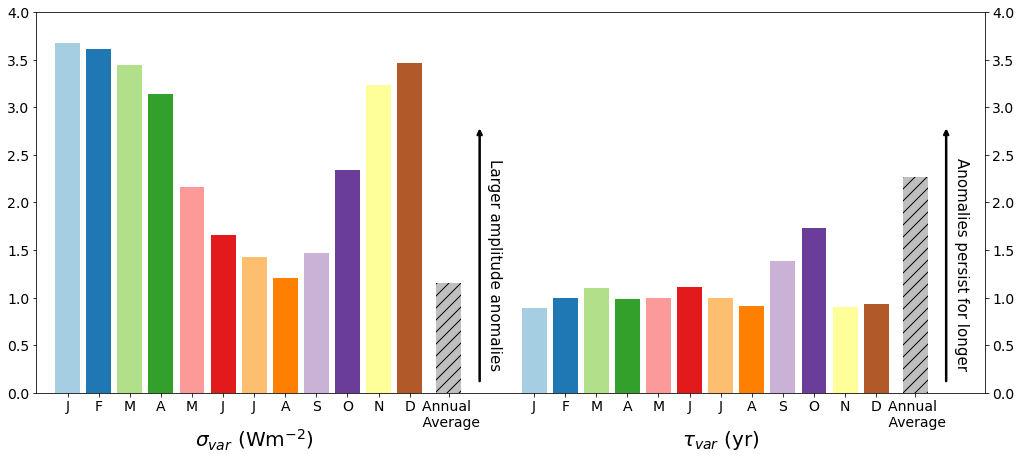

In [13]:
var_fig,var_ax = plt.subplots(1,1,figsize=(17,7))
var_ax.tick_params(labelright=True,right=True)

sigma_x = np.arange(1,13)
tau_x   = 15 + np.arange(1,13)

sigma_x_ann = [13.25]
tau_x_ann = [28.25]

colors = sns.color_palette("Paired") #+ [(0,0,0)]
month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','Annual \n Average']

var_ax.bar(sigma_x,lens_olr_data['stddev'][:-1],color=colors)
var_ax.bar(sigma_x_ann,lens_olr_data['stddev'][-1],color='black',hatch='//',alpha=0.25)

var_ax.bar(tau_x,lens_olr_data['tauvar'][:-1],color=colors)
var_ax.bar(tau_x_ann,lens_olr_data['tauvar'][-1],color='black',hatch='//',alpha=0.25)

var_ax.set_xticks(np.concatenate([sigma_x,sigma_x_ann,tau_x,tau_x_ann]))
var_ax.set_xticklabels(month_labels + month_labels,fontsize=14)
var_ax.set_xlim(0,30.5)
var_ax.set_ylim(0,4)

var_ax.tick_params(axis='both',labelsize=14)

var_ax.text(7,-0.5,r'$\sigma_{var}$ (Wm$^{-2}$)',fontsize=20,ha='center', va='center')
var_ax.text(22,-0.5,r'$\tau_{var}$ (yr)',fontsize=20,ha='center', va='center')

var_ax.annotate("", xy=(14.25, 2.8), xytext=(14.25, 0.1),
            arrowprops=dict(arrowstyle="->",lw=2.5,),annotation_clip=False)
var_ax.annotate("", xy=(29.25, 2.8), xytext=(29.25, 0.1),
            arrowprops=dict(arrowstyle="->",lw=2.5,),annotation_clip=False)

var_ax.text(14.5,1.35,'Larger amplitude anomalies',fontsize=15,rotation=270,va='center') # could be "fluctuations" instead
var_ax.text(29.5,1.35,'Anomalies persist for longer',fontsize=15,rotation=270,va='center')

In [14]:
to_png(file=var_fig,filename='fig_monthly_variability_comparison',dpi=300,ext='pdf',bbox_inches='tight')

Getting these values from fig6_OLRemergence

In [15]:
# monthly_30year_trends = np.array([0.15779349, 0.12256501, 0.09612695, 0.09433513, 0.07480197,
#        0.05322904, 0.05126559, 0.07933663, 0.1256753 , 0.2010181 ,
#        0.24432801, 0.1927263 ])

monthly_30year_trends = xr.DataArray(
    data = np.array([0.1577, 0.1225, 0.0961, 0.0943, 0.0748,
                     0.0532, 0.0512, 0.0793, 0.125 , 0.201 ,
                     0.2443, 0.1927]),
    dims = ['month'],
    coords = {'month': np.arange(1,13)}
)

Now getting the trends for the year closest to emergence.

Mean emergence for each month calculated from the Leroy-Phojan method (very close to Weatherhead).

emergence_LP_all.mean(dim='ens') =
array([31.475, 35.975, 40.425, 40.45 , 37.35 , 39.45 , 33.725, 24.425,
       22.55 , 23.975, 22.525, 26.8)

Code in "fig6_....ipynb"

trends_at_emerge = []

for month_emerge,month_trends in zip(emergence_LP_all.mean(dim='ens'),olr_slopes_monthly.mean(dim='ens')):
    
    emerge_trend =  month_trends.sel(duration=month_emerge,method='nearest')
    trends_at_emerge.append(emerge_trend)
    
trends_at_emerge = np.array(trends_at_emerge)

In [16]:
monthly_emergence_trends = xr.DataArray(
    np.array([0.1559884 , 0.12656918, 0.10751845, 0.08802388, 0.06608555,
           0.05506862, 0.04973755, 0.07845972, 0.12724987, 0.19600438,
           0.22476607, 0.19423492]),
    dims = ['month'],
    coords = {'month': np.arange(1,13)}
)

In [17]:
def time_to_emergence(tau_var,sigma_var,m_est,s=2):
    
    return (12* s**2 * tau_var * sigma_var**2 * m_est**(-2))**(1/3)

In [18]:
avgmonth_sigmavar = lens_olr_data['stddev'].sel(month=slice(1,12)).mean()

avgmonth_tauvar = lens_olr_data['tauvar'].sel(month=slice(1,12)).mean()

avgmonth_30year_trend = monthly_30year_trends.mean(dim='month')
avgmonth_emergence_trend = monthly_emergence_trends.mean(dim='month')

In [19]:
avgmonth_emergence = time_to_emergence(tau_var=avgmonth_tauvar,
                                       sigma_var=avgmonth_sigmavar,
                                       m_est=avgmonth_emergence_trend
                                       # m_est=avgmonth_30year_trend
                                      )

In [20]:
avgmonth_emergence

<xarray.DataArray ()>
array(28.35928067)
Coordinates:
    variable  <U4 'FLUT'

$$ TTE = (12s^2)^{1/3} \bar{\tau_{var}}^{1/3} \left( \frac{\tau_{var}}{\bar{\tau_{var}}} \right) ^{1/3} \bar{\sigma_{var}}^{2/3} \left( \frac{\sigma_{var}}{\bar{\sigma_{var}}} \right)^{2/3} \bar{m_{est}}^{-2/3} \left( \frac{\bar{m_{est}}}{m_{est}} \right)^{2/3} $$

$$ TTE_{avg} = (12s^2)^{1/3} \bar{\tau_{var}}^{1/3} \bar{\sigma_{var}}^{2/3} \bar{m_{est}}^{-2/3} $$

$$ TTE_{avg} = (12s^2)^{1/3} \overline{\tau_{var}}^{1/3} \bar{\sigma_{var}}^{2/3} \bar{m_{est}}^{-2/3} $$

$$ TTE_{avg} = \left( \frac{12s^2 \bar{\tau_{var}} \bar{\sigma_{var}}^{2}}{ \bar{m_{est}}^{2}} \right)^{1/3} $$

$$ TTE = TTE_{avg} \left( \frac{\tau_{var}}{\bar{\tau_{var}}} \right)^{1/3} \left( \frac{\sigma_{var}}{\bar{\sigma_{var}}} \right)^{2/3} \left( \frac{\bar{m_{est}}}{m_{est}} \right)^{2/3} $$

I want to plot and calculate these residual terms to show which ones explain the monthly variation in TTE.

In [21]:
tauvar_residual = (lens_olr_data['tauvar'] / avgmonth_tauvar)**(1/3)

In [22]:
stddev_residual = (lens_olr_data['stddev'] / avgmonth_sigmavar)**(2/3)

In [23]:
# trend_residual = (monthly_30year_trends / avgmonth_30year_trend)**(-2/3)
trend_residual = (monthly_emergence_trends / avgmonth_emergence_trend)**(-2/3)

In [24]:
total_residual = tauvar_residual * stddev_residual * trend_residual

Text(13, 0.35, 'Delayed OLR emergence')

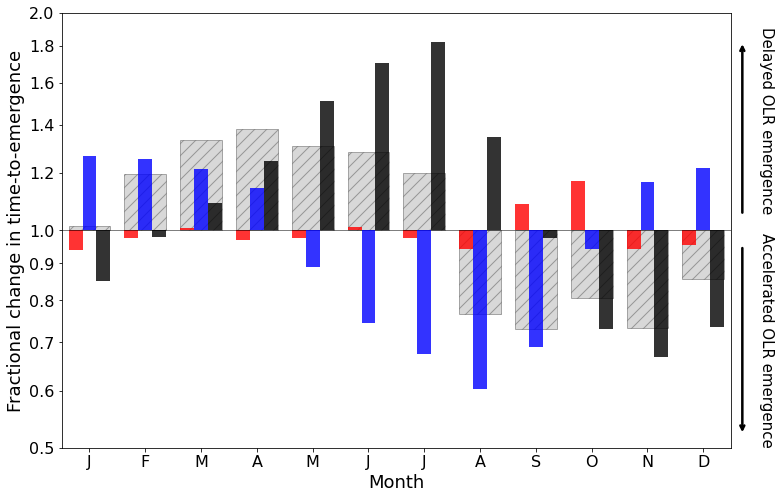

In [27]:
fig,ax = plt.subplots(1,1,figsize=(12,8))

month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']

tauvar_resid_log = np.log(tauvar_residual.sel(month=slice(1,12)))
stddev_resid_log = np.log(stddev_residual.sel(month=slice(1,12)))
trend_resid_log  = np.log(trend_residual)
total_resid_log  = np.log(total_residual)

ax.bar(np.arange(1,13)-0.25,tauvar_resid_log,width=0.25,
       color='red',label=r'Fractional TTE change due to $\tau_{var}$',alpha=0.8,
       zorder=1)
ax.bar(np.arange(1,13),stddev_resid_log,width=0.25,
       color='blue',label='Fractional TTE change due to $\sigma_{var}$',alpha=0.8,
       zorder=2)
       
ax.bar(np.arange(1,13)+0.25,trend_resid_log,width=0.25,
       color='black',label='Fractional TTE change due to $m_{est}$',alpha=0.8,
       zorder=3)

# ax.scatter(np.arange(1,13),total_resid_log,
#            label='Total Fractional TTE change',marker='*',color='orange',edgecolors= "black",s=150,
#            zorder=4)

ax.bar(np.arange(1,13),total_resid_log,width=0.75,
       label='Total Fractional TTE change',color='grey',alpha=0.3,hatch='//',edgecolor='black',
       zorder=0)

ax.set_xlabel('Month',fontsize=18)
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(month_labels,fontsize=16)
ax.hlines(y=0,xmin=0,xmax=13,color='black',alpha=0.5,linewidth=1,)
ax.set_xlim(0.5,12.5)

# np.arange(0.5,1.91,0.1)
yticks = np.concatenate([np.arange(0.5,1.0,0.1),np.arange(1,2.01,0.2)])

ax.set_ylabel('Fractional change in time-to-emergence',fontsize=18)
ax.set_yticks(np.log(yticks))
ax.set_yticklabels(np.round(yticks,1),fontsize=16)
ax.set_ylim(np.log(0.5),np.log(2.0))

# Legend too complicated for the figure. I'll keep it in a caption.
# ax.legend()

props = dict(facecolor='white', alpha=1)

ax.annotate("", xy=(12.7, 0.6), xytext=(12.7, 0.05),
            arrowprops=dict(arrowstyle="->",lw=2.5,),annotation_clip=False)
ax.annotate("", xy=(12.7, -0.65), xytext=(12.7, -0.05),
            arrowprops=dict(arrowstyle="->",lw=2.5,),annotation_clip=False)

ax.text(13,-0.35,'Accelerated OLR emergence',fontsize=15,rotation=270,va='center')
ax.text(13,0.35,'Delayed OLR emergence',fontsize=15,rotation=270,va='center')

# ax.text(13,-0.35,'Decreased time-to-emergence',fontsize=14,rotation=270,va='center')
# ax.text(13,0.35,'Increased time-to-emergence',fontsize=14,rotation=270,va='center')

In [28]:
to_png(file=fig,filename='fig_emergence_decomposition',dpi=300,ext='pdf',bbox_inches='tight')

Text(13, 0.35, 'Delayed OLR emergence')

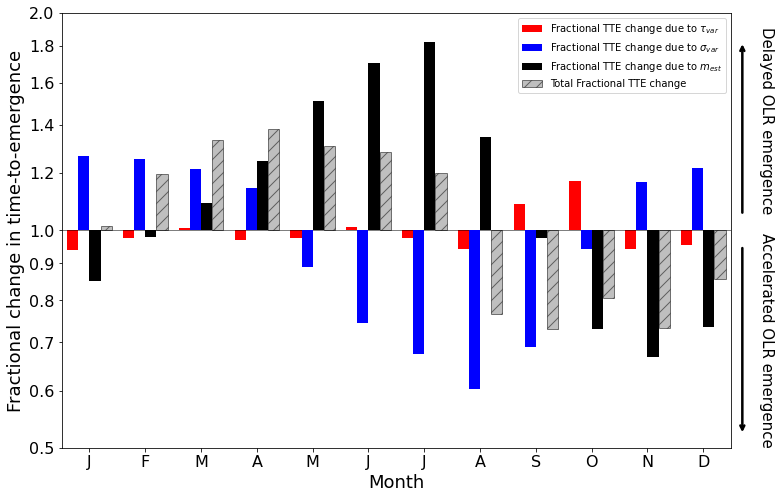

In [202]:
fig,ax = plt.subplots(1,1,figsize=(12,8))

month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']

tauvar_resid_log = np.log(tauvar_residual.sel(month=slice(1,12)))
stddev_resid_log = np.log(stddev_residual.sel(month=slice(1,12)))
trend_resid_log  = np.log(trend_residual)
total_resid_log  = np.log(total_residual)

ax.bar(np.arange(1,13)-0.30,tauvar_resid_log,width=0.20,
       color='red',label=r'Fractional TTE change due to $\tau_{var}$',alpha=1,
       zorder=1)
ax.bar(np.arange(1,13)-0.10,stddev_resid_log,width=0.20,
       color='blue',label='Fractional TTE change due to $\sigma_{var}$',alpha=1,
       zorder=2)
       
ax.bar(np.arange(1,13)+0.10,trend_resid_log,width=0.20,
       color='black',label='Fractional TTE change due to $m_{est}$',alpha=1,
       zorder=3)

ax.bar(np.arange(1,13)+0.30,total_resid_log,width=0.20,
       label='Total Fractional TTE change',color='grey',alpha=0.5,hatch='//',edgecolor='black',
       zorder=0)

# ax.scatter(np.arange(1,13),total_resid_log,
#            label='Total Fractional TTE change',marker='*',color='orange',edgecolors= "black",s=150,
#            zorder=4)

# ax.bar(np.arange(1,13),total_resid_log,width=0.75,
#        label='Total Fractional TTE change',color='grey',alpha=0.15,hatch='//',edgecolor='black',
#        zorder=0)

ax.set_xlabel('Month',fontsize=18)
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(month_labels,fontsize=16)
ax.hlines(y=0,xmin=0,xmax=13,color='black',alpha=0.5,linewidth=1,)
ax.set_xlim(0.5,12.5)

# np.arange(0.5,1.91,0.1)
yticks = np.concatenate([np.arange(0.5,1.0,0.1),np.arange(1,2.01,0.2)])

ax.set_ylabel('Fractional change in time-to-emergence',fontsize=18)
ax.set_yticks(np.log(yticks))
ax.set_yticklabels(np.round(yticks,1),fontsize=16)
ax.set_ylim(np.log(0.5),np.log(2.0))

ax.legend()

props = dict(facecolor='white', alpha=1)

ax.annotate("", xy=(12.7, 0.6), xytext=(12.7, 0.05),
            arrowprops=dict(arrowstyle="->",lw=2.5,),annotation_clip=False)
ax.annotate("", xy=(12.7, -0.65), xytext=(12.7, -0.05),
            arrowprops=dict(arrowstyle="->",lw=2.5,),annotation_clip=False)

ax.text(13,-0.35,'Accelerated OLR emergence',fontsize=15,rotation=270,va='center')
ax.text(13,0.35,'Delayed OLR emergence',fontsize=15,rotation=270,va='center')

# ax.text(13,-0.35,'Decreased time-to-emergence',fontsize=14,rotation=270,va='center')
# ax.text(13,0.35,'Increased time-to-emergence',fontsize=14,rotation=270,va='center')

I need to pick the trend at the time of emergence to get everything right here. __But it fixed things!!!__

Also the multiplying is confusing, because fractions don't add...not sure how to fix this since their will be cross-terms that have no physical meaning.

Older mock-up stuff.

In [5]:
obs_test_data  = obs_data.sel(variable='FLUTC_CERES')
lens_test_data = lens_data.sel(variable='FLUTC')

In [7]:
for _stddev,_tauvar in zip(obs_test_data['stddev'],obs_test_data['tauvar']):
    print(_stddev,_tauvar)

<xarray.DataArray 'stddev' ()>
array(2.914636)
Coordinates:
    variable  <U11 'FLUTC_CERES'
    month     int64 1 <xarray.DataArray 'tauvar' ()>
array(1.)
Coordinates:
    variable  <U11 'FLUTC_CERES'
    month     int64 1
<xarray.DataArray 'stddev' ()>
array(3.805695)
Coordinates:
    variable  <U11 'FLUTC_CERES'
    month     int64 2 <xarray.DataArray 'tauvar' ()>
array(1.)
Coordinates:
    variable  <U11 'FLUTC_CERES'
    month     int64 2
<xarray.DataArray 'stddev' ()>
array(3.33328)
Coordinates:
    variable  <U11 'FLUTC_CERES'
    month     int64 3 <xarray.DataArray 'tauvar' ()>
array(1.)
Coordinates:
    variable  <U11 'FLUTC_CERES'
    month     int64 3
<xarray.DataArray 'stddev' ()>
array(2.15305)
Coordinates:
    variable  <U11 'FLUTC_CERES'
    month     int64 4 <xarray.DataArray 'tauvar' ()>
array(1.)
Coordinates:
    variable  <U11 'FLUTC_CERES'
    month     int64 4
<xarray.DataArray 'stddev' ()>
array(1.413011)
Coordinates:
    variable  <U11 'FLUTC_CERES'
    month    

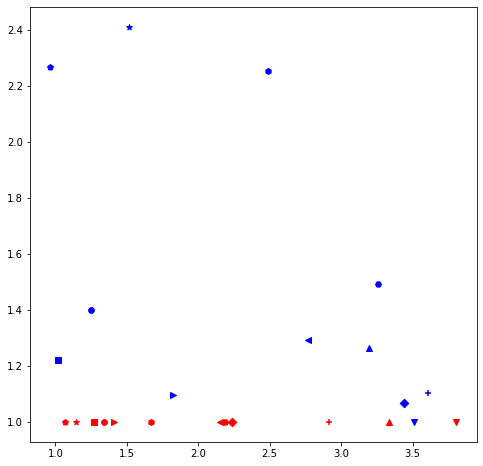

In [8]:
test_fig,test_ax = plt.subplots(1,1,figsize=(8,8))

markers = ('+', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D')

for _stddev,_tauvar,_marker in zip(obs_test_data['stddev'],obs_test_data['tauvar'],markers):
    # print(_stddev,_tauvar)
    test_ax.scatter(_stddev,_tauvar,marker=_marker,color='red')
    
for _stddev,_tauvar,_marker in zip(lens_test_data['stddev'],lens_test_data['tauvar'],markers):
    test_ax.scatter(_stddev,_tauvar,marker=_marker,color='blue')

# test_ax.scatter(obs_test_data['stddev'],obs_test_data['tauvar'],marker=('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D'))

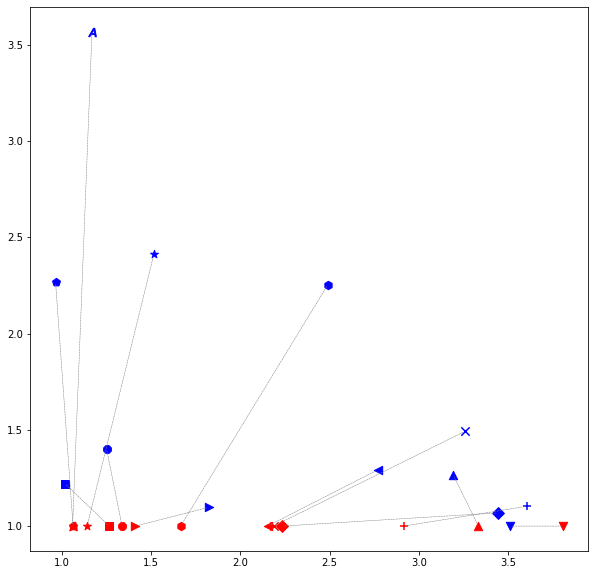

In [9]:
test_fig,test_ax = plt.subplots(1,1,figsize=(10,10))

markers = ('+', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'x', 'D','$A$')
iterator = zip(obs_test_data['stddev'],obs_test_data['tauvar'],lens_test_data['stddev'],lens_test_data['tauvar'],markers)
for _stddev_obs,_tauvar_obs,_stddev_lens,_tauvar_lens,_marker in iterator:
    # print(_stddev,_tauvar)
    test_ax.scatter(_stddev_obs,_tauvar_obs,marker=_marker,color='red',s=70)
    test_ax.scatter(_stddev_lens,_tauvar_lens,marker=_marker,color='blue',s=70)
    
    # mlines.Line2D([_stddev_obs,_stddev_lens], [_tauvar_obs,_tauvar_lens])
    # test_ax.plot(_stddev_obs,_tauvar_obs,_stddev_lens,_tauvar_lens, marker = 'o')
    
    test_ax.annotate("",
            xy=(_stddev_obs,_tauvar_obs), xycoords='data',
            xytext=(_stddev_lens,_tauvar_lens), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            lw=0.5,
                            ls='dashed',
                            color='gray',
                            # connectionstyle="arc3",
                           ),
            )


In [10]:
obs_data

<xarray.Dataset>
Dimensions:   (month: 13, variable: 4)
Coordinates:
  * variable  (variable) object 'FLUTC_CERES' 'FLUT_CERES' ... 'TS_GISSTEMP'
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
Data variables:
    stddev    (variable, month) float64 ...
    tauvar    (variable, month) float64 ...
Attributes:
    description:  \nStandard deviation and autocorrelation time for selected ...

FLUTC_CERES FLUTC
FLUT_CERES FLUT
TS_BESTTEMP TS
TS_GISSTEMP TS


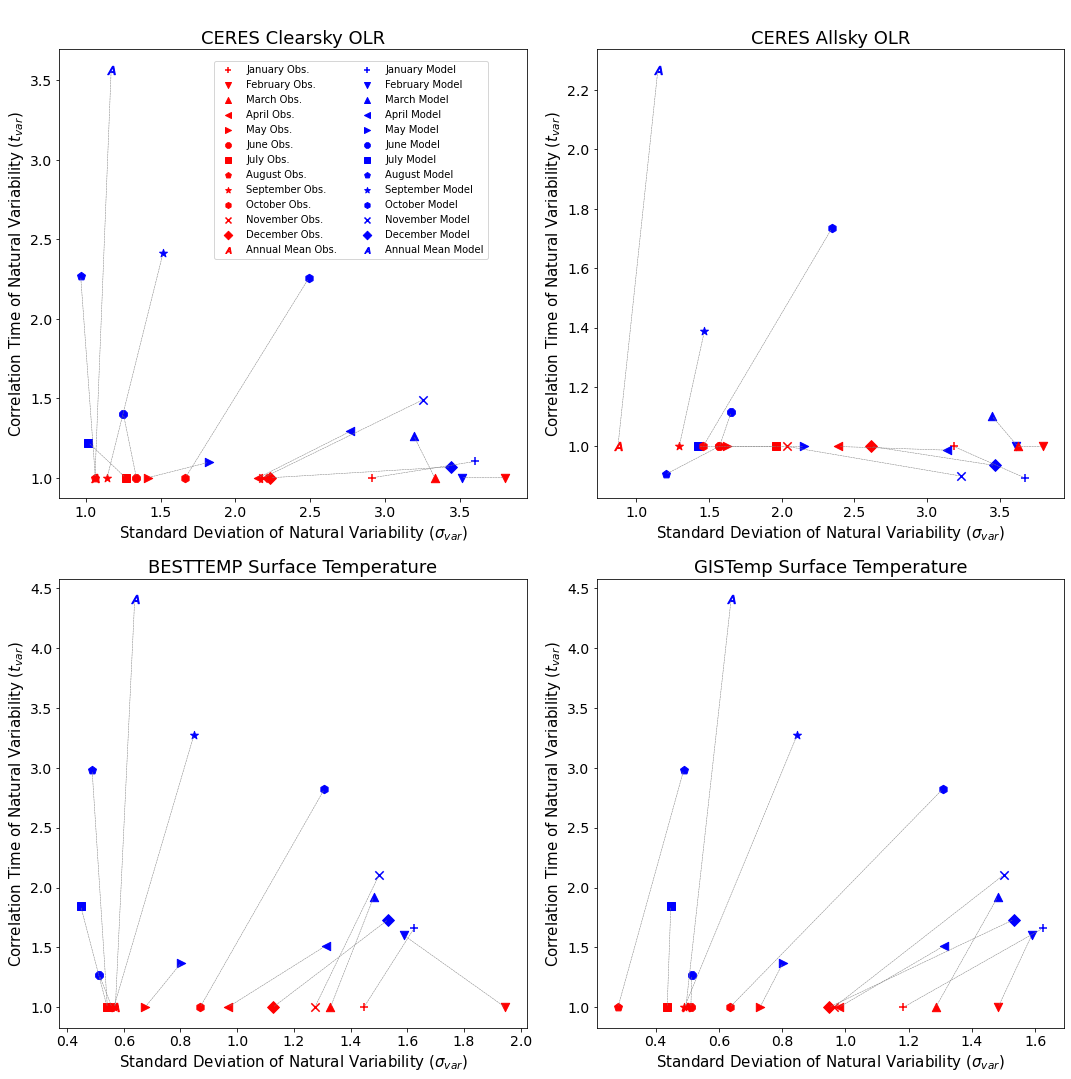

In [11]:
comp_fig,comp_axs = plt.subplots(2,2,figsize=(18,18))
comp_axs = comp_axs.flat

markers        = ('+', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'x', 'D','$A$')
markers_labels = ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Annual Mean')

obs_vars   = ['FLUTC_CERES', 'FLUT_CERES', 'TS_BESTTEMP', 'TS_GISSTEMP']
lens_vars  = ['FLUTC', 'FLUT', 'TS', 'TS']
label_vars = ['CERES Clearsky OLR','CERES Allsky OLR','BESTTEMP Surface Temperature','GISTemp Surface Temperature']

for _obs_var,_lens_var,_label_var,_ax in zip(obs_vars,lens_vars,label_vars,comp_axs):
    print(_obs_var,_lens_var)
    obs_var  = obs_data.sel(variable=_obs_var)
    lens_var = lens_data.sel(variable=_lens_var)
    
    for _month,_marker in zip(obs_data.month,markers):
        _stddev_obs  = obs_var['stddev'].sel(month=_month)
        _tauvar_obs  = obs_var['tauvar'].sel(month=_month)
        _stddev_lens = lens_var['stddev'].sel(month=_month)
        _tauvar_lens = lens_var['tauvar'].sel(month=_month)
        
        _ax.scatter(_stddev_obs,_tauvar_obs,marker=_marker,color='red',s=70)
        _ax.scatter(_stddev_lens,_tauvar_lens,marker=_marker,color='blue',s=70)

        _ax.annotate("",
                xy=(_stddev_obs,_tauvar_obs), xycoords='data',
                xytext=(_stddev_lens,_tauvar_lens), textcoords='data',
                arrowprops=dict(arrowstyle="-",
                                lw=0.5,
                                ls='dashed',
                                color='gray',
                                # connectionstyle="arc3",
                               ),
                )
        
    # set axis labels, etc
    _ax.set_ylabel('Correlation Time of Natural Variability ($t_{var}$)',fontsize=15)
    _ax.set_xlabel('Standard Deviation of Natural Variability ($\sigma_{var}$)',fontsize=15)
    _ax.set_title(_label_var,fontsize=18)
    _ax.tick_params(axis='both', labelsize=14)
    # _ax.tick_params(axis='y', labelsize=14)
    # _ax.set_xticklabels(fontsize=20)
    # _ax.set_xticklabels(_ax.get_xticklabels(),fontsize=12)
    
# Prep fake legend
obs_lines  = []
lens_lines = []
for _month,_marker,_marker_label in zip(obs_data.month,markers,markers_labels):
    _obs_line  = _ax.scatter(np.nan,np.nan,marker=_marker,color='red',label=_marker_label + ' Obs.')
    _lens_line = _ax.scatter(np.nan,np.nan,marker=_marker,color='blue',label=_marker_label + ' Model')
    obs_lines.append(_obs_line)
    lens_lines.append(_lens_line)
lines = obs_lines + lens_lines
    
comp_fig.legend(handles=lines,loc=(0.2,0.76),ncol=2)
comp_fig.subplots_adjust(hspace=0.18,wspace=0.15)

In [127]:
# to_png(comp_fig,filename='noise_comparison',bbox_inches='tight')

In [13]:
lens_data

<xarray.Dataset>
Dimensions:   (month: 13, variable: 9)
Coordinates:
  * variable  (variable) object 'FLUT' 'FLUTC' 'FSNS' ... 'ICEFRAC' 'TMQ' 'TS'
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
Data variables:
    stddev    (variable, month) float64 ...
    tauvar    (variable, month) float64 ...
Attributes:
    description:  \nStandard deviation and autocorrelation time for selected ...

$\tau_{var}$

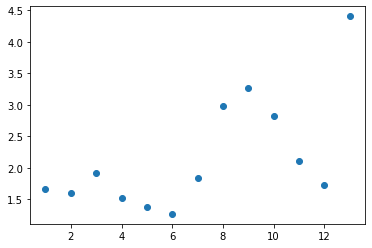

In [15]:
plt.scatter(lens_data['month'],lens_data['tauvar'].sel(variable='TS'))

$\sigma_{var}$

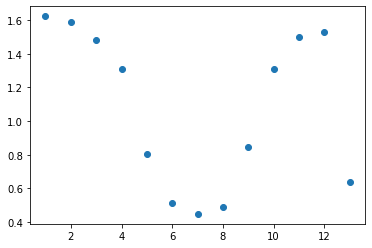

In [16]:
plt.scatter(lens_data['month'],lens_data['stddev'].sel(variable='TS'))

$\sigma_{var}^2 \tau_{var}$

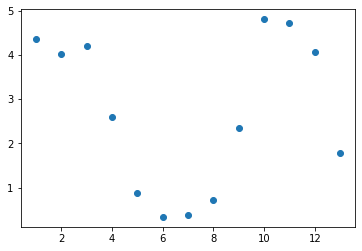

In [19]:
plt.scatter(lens_data['month'],(lens_data['stddev'].sel(variable='TS')**2*lens_data['tauvar'].sel(variable='TS')))

$\tau_{var}$

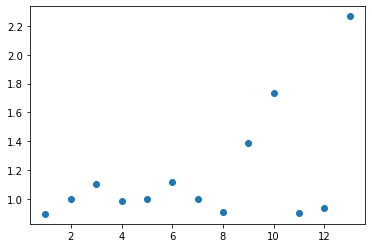

In [17]:
plt.scatter(lens_data['month'],lens_data['tauvar'].sel(variable='FLUT'))

$\sigma_{var}$

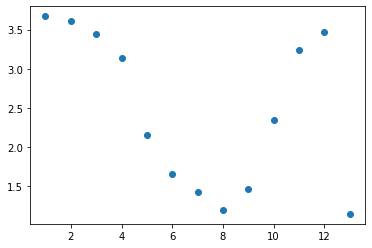

In [18]:
plt.scatter(lens_data['month'],lens_data['stddev'].sel(variable='FLUT'))

$\sigma_{var}^2 \tau_{var}$

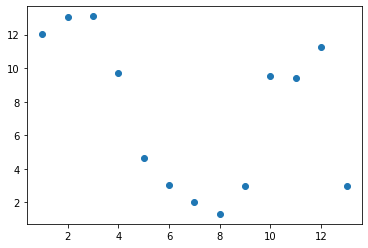

In [20]:
plt.scatter(lens_data['month'],(lens_data['stddev'].sel(variable='FLUT')**2*lens_data['tauvar'].sel(variable='FLUT')))